In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data_dir = os.path.join("..", "assets", "inference-results", "isolated")

ce_dir = os.path.join(data_dir, "cross-entropy", "grad-accumulation")
fl_dir = os.path.join(data_dir, "focal-loss", "grad-accumulation")

all([os.path.isdir(ce_dir), os.path.isdir(fl_dir)])

True

In [3]:
splits = [split for split in os.listdir(ce_dir)]

ce_splits = [os.path.join(ce_dir, split) for split in splits]
fl_splits = [os.path.join(fl_dir, split) for split in splits]

In [4]:
ce_parquets = [os.path.join(split, "attention-mil-instance-weights.parquet") for split in ce_splits]

fl_parquets = [os.path.join(split, "attention-mil-instance-weights.parquet") for split in fl_splits]

In [5]:
cols = ["patient_id", "attention_weights"]
ce_dfs = pd.DataFrame(columns=cols)

for f in ce_parquets:
    ce_df = pd.read_parquet(f)
    ce_df["attention_weights"] = ce_df["attention_weights"].map(lambda x: (x - x.min()) / (x.max() - x.min()))
    ce_dfs = pd.concat([ce_dfs, ce_df], ignore_index=True)

ce_concatenated_attention = np.concat(ce_dfs["attention_weights"])

In [6]:
cols = ["patient_id", "attention_weights"]
fl_dfs = pd.DataFrame(columns=cols)

for f in fl_parquets:
    fl_df = pd.read_parquet(f)
    fl_df["attention_weights"] = fl_df["attention_weights"].map(lambda x: (x - x.min()) / (x.max() - x.min()))
    fl_dfs = pd.concat([fl_dfs, fl_df], ignore_index=True)

fl_concatenated_attention = np.concat(fl_dfs["attention_weights"])

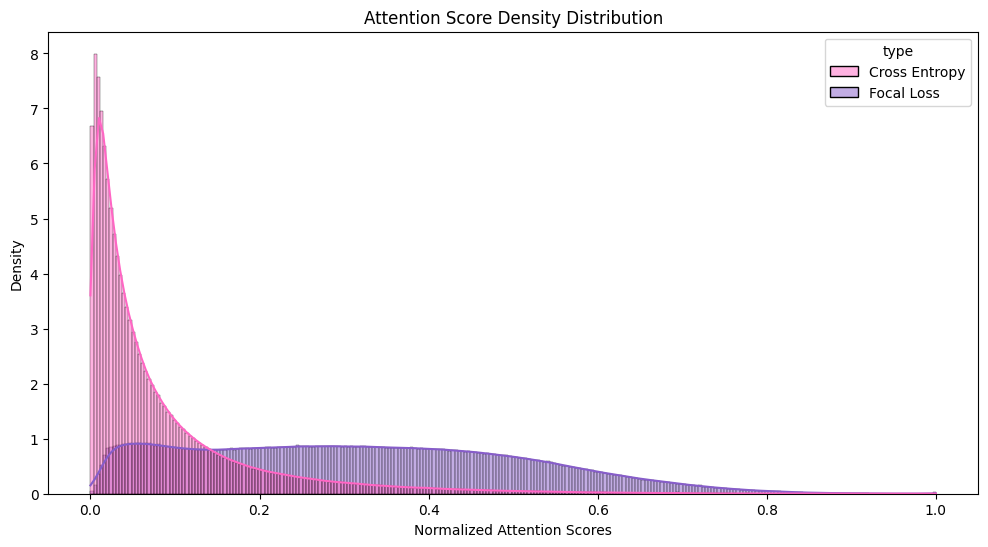

In [7]:
combined_df = pd.DataFrame({
    "attention_weights": np.concat([ce_concatenated_attention, fl_concatenated_attention]),
    "type": ["Cross Entropy"] * len(ce_concatenated_attention) + ["Focal Loss"] * len(fl_concatenated_attention)
})

colors = ["#ff66c4", "#875dca"]
plt.figure(figsize=(12, 6))
sns.histplot(
    data=combined_df, 
    x="attention_weights", 
    hue="type", 
    bins="auto", 
    kde=True, 
    stat="density",
    palette=colors
    )

plt.title("Attention Score Density Distribution")
plt.xlabel("Normalized Attention Scores")
plt.ylabel("Density")

plt.show()

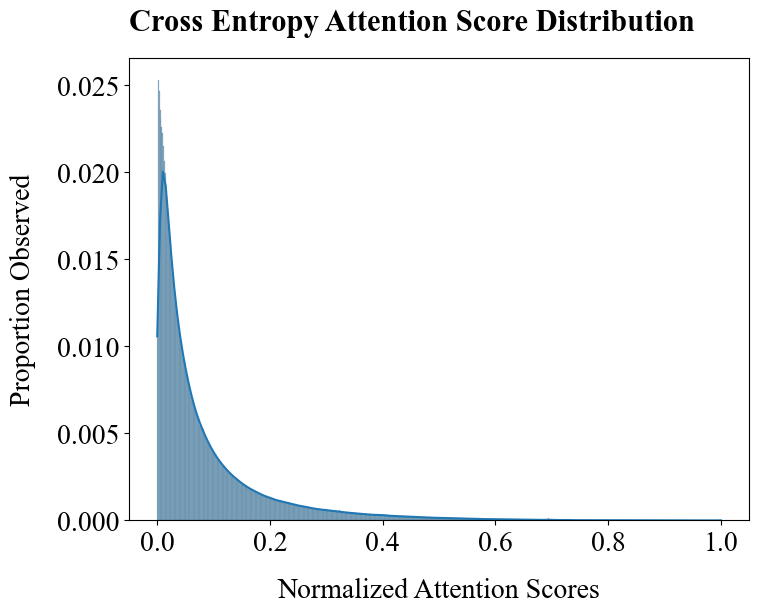

In [8]:
combined_df = pd.DataFrame({
    "attention_weights": np.concatenate([ce_concatenated_attention, fl_concatenated_attention]),
    "Loss": ["Cross Entropy"] * len(ce_concatenated_attention) + ["Focal Loss"] * len(fl_concatenated_attention)
})

colors = ["#ff66c4", "#cb6ce6"]

# Cross Entropy histogram in a separate figure
plt.figure(figsize=(8, 6))
sns.histplot(
    data=combined_df[combined_df["Loss"] == "Cross Entropy"], 
    x="attention_weights", 
    bins="auto", 
    kde=True, 
    # color=colors[0],
    stat="probability"
)
plt.title("Cross Entropy Attention Score Distribution",fontsize=22, weight="bold", fontname="Times New Roman", loc="left", pad=20)
plt.xlabel("Normalized Attention Scores",fontsize=20, fontname="Times New Roman", labelpad=15)
plt.ylabel("Proportion Observed",fontsize=20, fontname="Times New Roman", labelpad=15)
plt.xticks(fontsize=20, fontname="Times New Roman")
plt.yticks(fontsize=20, fontname="Times New Roman")
plt.show()

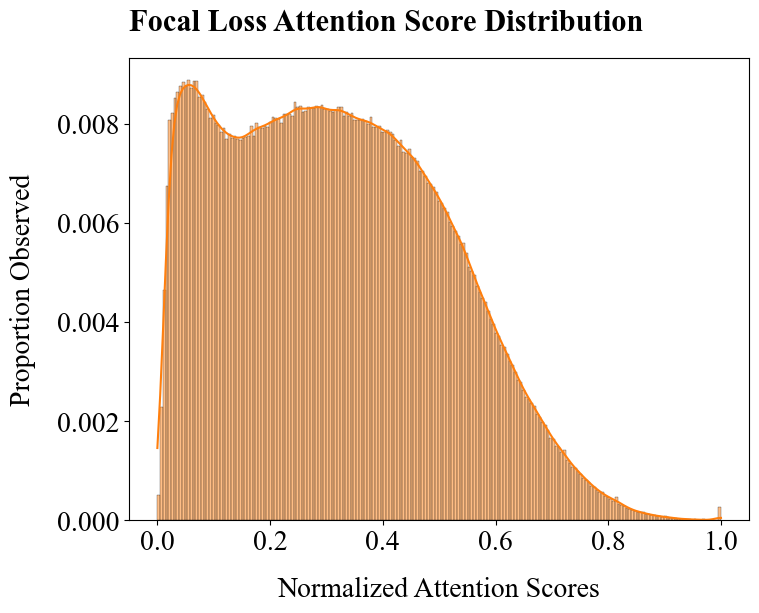

In [10]:
# Focal Loss histogram in a separate figure
plt.figure(figsize=(8, 6))
sns.histplot(
    data=combined_df[combined_df["Loss"] == "Focal Loss"], 
    x="attention_weights", 
    bins="auto", 
    kde=True, 
    # color=colors[1],
    color=sns.color_palette()[1],
    stat="probability"
)
plt.title("Focal Loss Attention Score Distribution", fontsize=22, weight="bold", fontname="Times New Roman", loc="left", pad=20)
plt.xlabel("Normalized Attention Scores", fontsize=20, fontname="Times New Roman", labelpad=15)
plt.ylabel("Proportion Observed",fontsize=20, fontname="Times New Roman", labelpad=15)
plt.xticks(fontsize=20, fontname="Times New Roman")
plt.yticks(fontsize=20, fontname="Times New Roman")
plt.show()

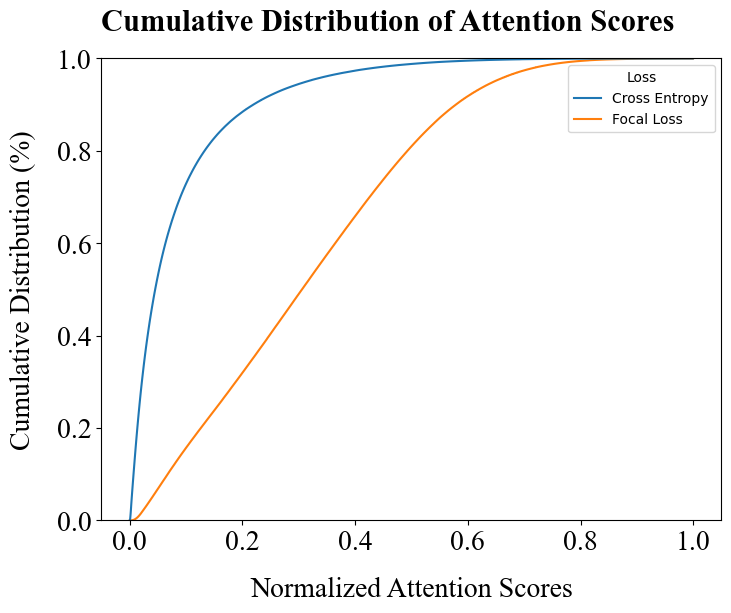

In [11]:
plt.figure(figsize=(8, 6))
sns.ecdfplot(
    data=combined_df, 
    x="attention_weights", 
    hue="Loss", 
    stat="proportion",
    # palette=colors
    )

plt.title("Cumulative Distribution of Attention Scores", fontsize=22, weight="bold", fontname="Times New Roman", loc="left", pad=20)
plt.xlabel("Normalized Attention Scores",fontsize=20, fontname="Times New Roman", labelpad=15)
plt.ylabel("Cumulative Distribution (%)",fontsize=20, fontname="Times New Roman", labelpad=15)
plt.xticks(fontsize=20, fontname="Times New Roman")
plt.yticks(fontsize=20, fontname="Times New Roman")

plt.show()

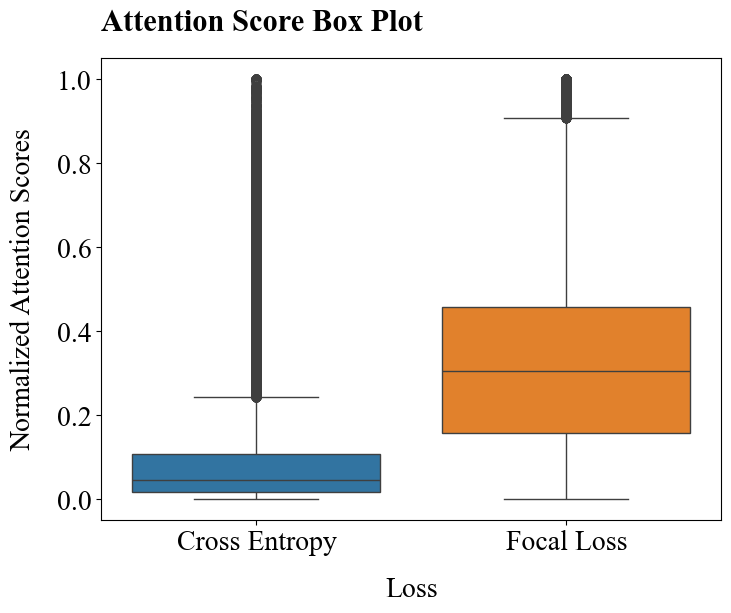

In [13]:
plt.figure(figsize=(8, 6))
# sns.boxplot(x="Loss", y="attention_weights", data=combined_df, hue="Loss", palette=colors)
sns.boxplot(x="Loss", y="attention_weights", data=combined_df, hue="Loss")
plt.title("Attention Score Box Plot", fontsize=22, weight="bold", fontname="Times New Roman", loc="left", pad=20)
plt.xlabel("Loss",fontsize=20, fontname="Times New Roman", labelpad=15)
plt.ylabel("Normalized Attention Scores",fontsize=20, fontname="Times New Roman", labelpad=15)
plt.xticks(fontsize=20, fontname="Times New Roman")
plt.yticks(fontsize=20, fontname="Times New Roman")

plt.show()

In [26]:
ce_df_test = pd.read_parquet(ce_parquets[3])
ce_df_test["attention_weights"] = ce_df_test["attention_weights"].map(lambda x: (x - x.min()) / (x.max() - x.min()))

ce_df_test.head()

,patient_id,attention_weights
0,12404,"[0.001948171, 0.0020451476, 0.0020372667, 0.00..."
1,11727,"[0.0026603404, 0.003114474, 0.008928046, 0.003..."
2,13424,"[0.015815752, 0.017023787, 0.022038233, 0.0298..."
3,16089,"[0.0119005805, 0.009316263, 0.00602791, 0.0086..."
4,11481,"[0.0014351858, 0.0032996498, 0.0027960972, 0.0..."


In [27]:
fl_df_test = pd.read_parquet(fl_parquets[3])
fl_df_test["attention_weights"] = fl_df_test["attention_weights"].map(lambda x: (x - x.min()) / (x.max() - x.min()))

fl_df_test.head()

,patient_id,attention_weights
0,12404,"[0.41099757, 0.44239014, 0.4944021, 0.39751524..."
1,11727,"[0.47407985, 0.49653977, 0.20655547, 0.3578471..."
2,13424,"[0.5006299, 0.42747477, 0.66925716, 0.45097572..."
3,16089,"[0.4209406, 0.401203, 0.37630448, 0.3090522, 0..."
4,11481,"[0.47183824, 0.47780952, 0.5044325, 0.55972457..."


In [28]:
ce_concatenated_attention = np.concat(ce_df_test["attention_weights"])

fl_concatenated_attention = np.concat(fl_df_test["attention_weights"])

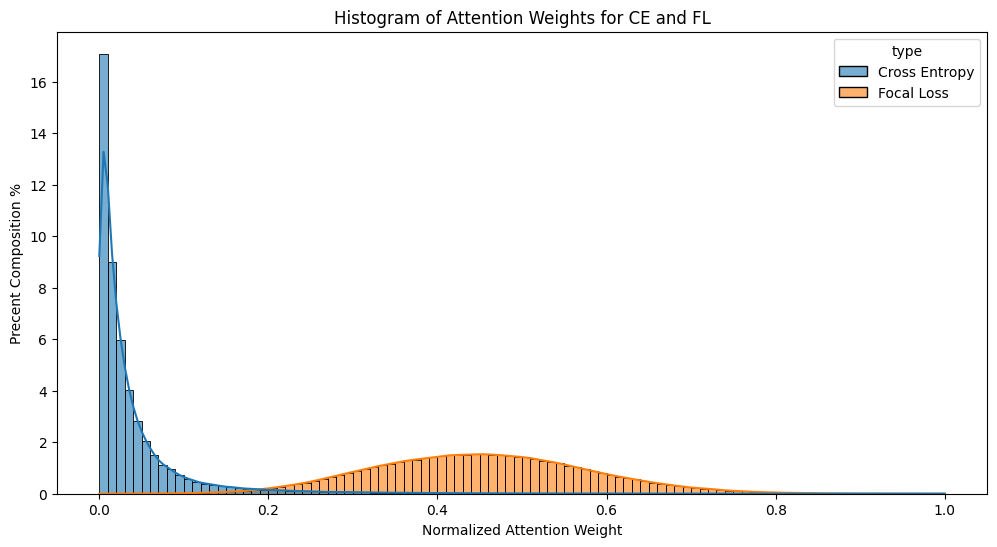

In [29]:
combined_df = pd.DataFrame({
    "attention_weights": np.concatenate([ce_concatenated_attention, fl_concatenated_attention]),
    "type": ["Cross Entropy"] * len(ce_concatenated_attention) + ["Focal Loss"] * len(fl_concatenated_attention)
})

plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x="attention_weights", hue="type", bins=100, kde=True, stat="percent", alpha=0.6)

plt.title("Histogram of Attention Weights for CE and FL")
plt.xlabel("Normalized Attention Weight")
plt.ylabel("Precent Composition %")

plt.show()

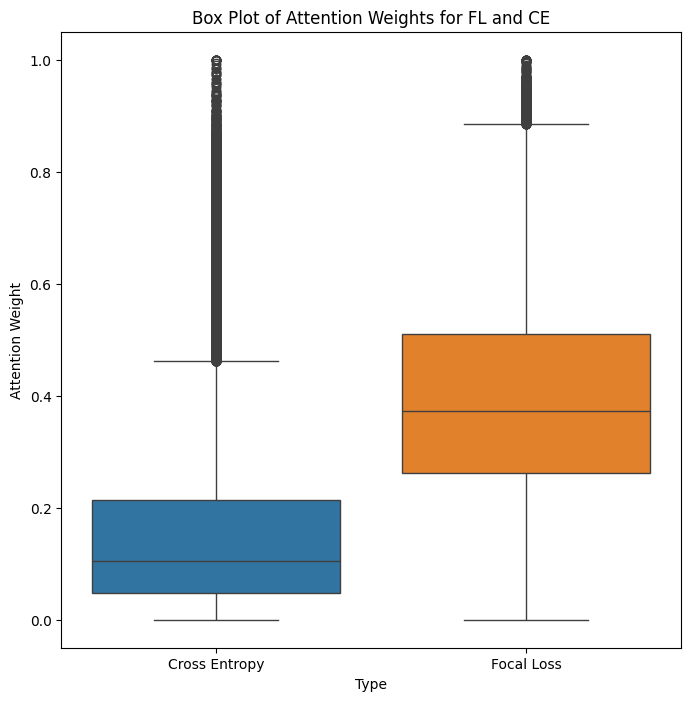

In [14]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="type", y="attention_weights", data=combined_df, hue="type")
plt.title("Box Plot of Attention Weights for FL and CE")
plt.xlabel("Type")
plt.ylabel("Attention Weight")
plt.show()

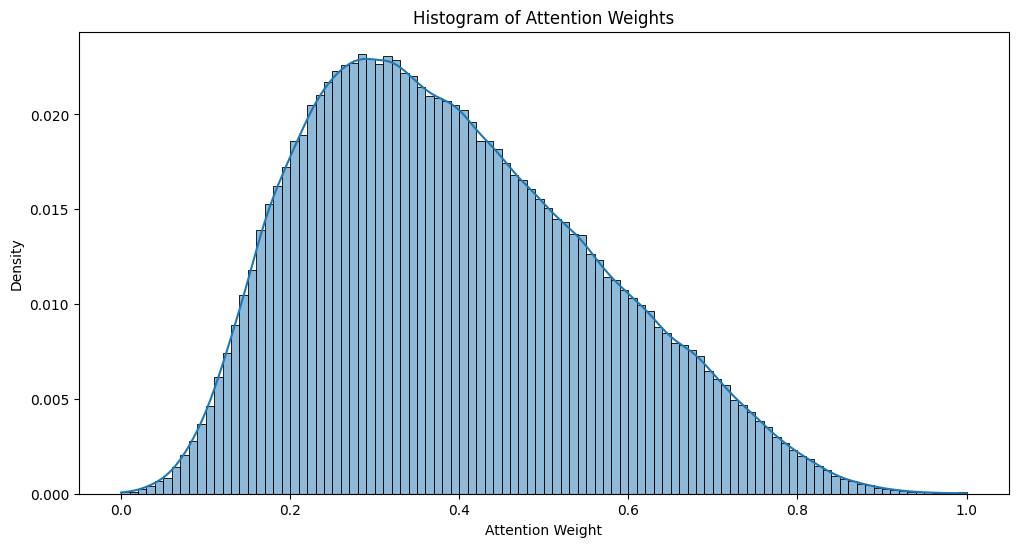

In [15]:
# FL

plt.figure(figsize=(12, 6))
sns.histplot(fl_concatenated_attention, bins=100, kde=True, stat="probability")
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Density")
plt.show()

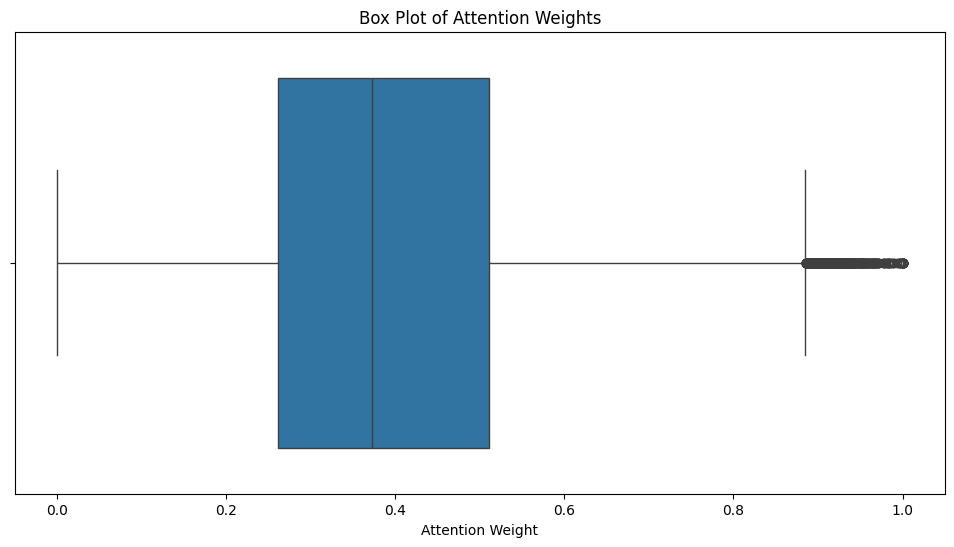

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=fl_concatenated_attention.flatten())
plt.title("Box Plot of Attention Weights")
plt.xlabel("Attention Weight")
plt.show()

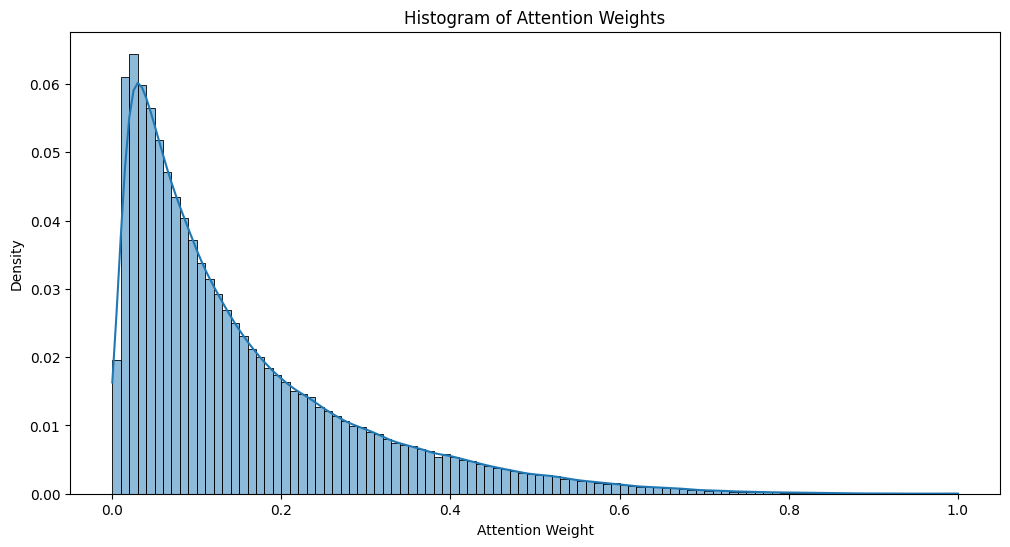

In [17]:
# CE

plt.figure(figsize=(12, 6))
sns.histplot(ce_concatenated_attention, bins=100, kde=True, stat="probability")
plt.title("Histogram of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Density")
plt.show()

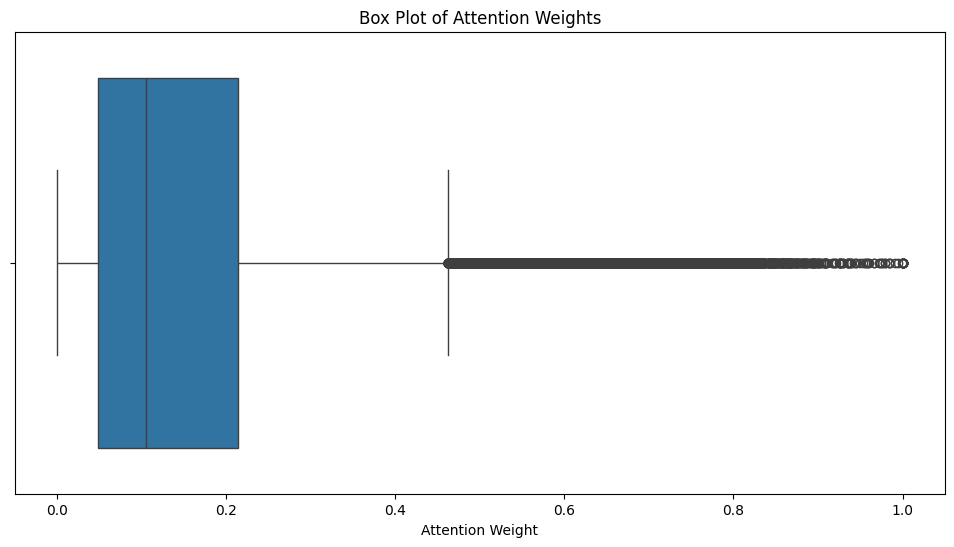

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=ce_concatenated_attention.flatten())
plt.title("Box Plot of Attention Weights")
plt.xlabel("Attention Weight")
plt.show()